In [1]:
import sys
sys.executable

'/usr/bin/python3'

In [2]:
from bs4 import BeautifulSoup
import numpy as np
from collections import Counter
import pandas as pd
import os
import re
import json
import openslide
from matplotlib import pyplot as plt
import cv2

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [32]:
from extract_rois_svs_xml import extract_rois_svs_xml, get_chunk_masks
from slideutils import (plot_contour, get_median_color, get_thumbnail_magnification,
        CropRotateRoi, get_img_bbox, get_rotated_highres_roi, get_uniform_tiles,
                       get_contour_centre, read_roi_patches_from_slide,
                       get_contours_from_mask, get_roi_dict,
                       clip_roi_wi_bbox, sample_points_wi_contour)

## Background

The histologic slides are huge. Loading a whole slide into memory might be not the best idea. Here we use some tricks to sample tissue based on hand-labelled features as well as grid sampling in combination with color thresholding (to remove blank space)

## Read XML ROI, convert, and save as JSON

In [4]:
fnxml = "../examples/97c83c47/c886827fe8c10b4699a0f1616331e36b46a05617.xml"
fnxml  = "/tmp/kidney/6b8110e5dfccd8b3665db70411f2ea518a6e6da3.xml"
fnxml  = "/tmp/kidney/3949a5388bd08cc24f368833d46865ed46b77c3a.xml"
fnsvs = re.sub(".xml$", ".svs", fnxml)

In [81]:
# this function converts xml to json and saves it
fnjson = extract_rois_svs_xml(fnxml, remove_empty=True)

counts of roi names
glom      42
tissue     8
dtype: int64


In [82]:
# now we read a json file
with open(fnjson,'r') as fh:
    roilist = json.load(fh)

In [73]:
pd.Series([roi["name"] for roi in roilist]).value_counts()#.index

glom      42
tissue     6
dtype: int64

## load the slide from SVS file

In [74]:
slide = openslide.OpenSlide(fnsvs)
img = np.asarray(slide.associated_images["thumbnail"])

median_color = get_median_color(slide)
ratio = get_thumbnail_magnification(slide)

In [75]:
slide.dimensions

(151624, 50132)

In [20]:
colordict = {'open glom': 'b',
             'glom': 'b',
             'scler glom': 'm',
             'infl':'r',
             'tissue':'k',
             'art':'olive',
             'fold':'y'}

number of chunks detected: 6


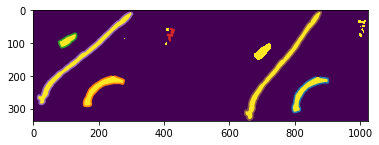

In [84]:
chunk_masks = get_chunk_masks(img)
chunk_countours = get_contours_from_mask(chunk_masks, minlen=70)
print("number of chunks detected:", len(chunk_countours))

plt.imshow(chunk_masks)
for cc in chunk_countours:
    plot_contour(cc)

In [77]:
chunk_rois = [get_roi_dict(cc, name='tissue', id=1+nn+len(roilist), sq_micron_per_pixel=1.0)
                          for nn,cc in enumerate(chunk_countours)]
len(chunk_rois)

8

In [12]:
# tissue_rois = [roi for roi in roilist if roi["name"]=="tissue"]
# feature_rois = [roi for roi in roilist if roi["name"]!="tissue"]
# len(tissue_rois), len(feature_rois)

In [52]:
from shapely.geometry import Polygon

def _shapely_polygon_from_roi_(roi):
    return Polygon(roi["vertices"])

def find_chunk_content(roilist):
    """finds features (gloms, infl, etc) contained within tissue chunks.
    Returns a dictionary:
    {tissue_chunk_1_id: [feature_1_id, ..., feature_n_id],
     tissue_chunk_1_id: [...]
    }
    Requires `shapely` package
    """
    pgs_tissue = {}
    pgs_feature = {}
    for roi in roilist:
    #     print(roi['id'], roi['name'])
        if roi["name"]=="tissue":
            pgs_tissue[roi['id']] = Polygon(roi["vertices"])
        else:
            pgs_feature[roi['id']] = Polygon(roi["vertices"])
#     print(sorted(list(pgs_feature.keys())))
    tissue_contains = dict(zip(pgs_tissue.keys(), [[] for _ in range(len(pgs_tissue))]))
    remove_items = []
    for idt, pt in pgs_tissue.items():
        for idf in remove_items:
#             print("popping", idf)
            pgs_feature.pop(idf)
        remove_items = []
        for idf, pf in pgs_feature.items():
            if pt.intersects(pf):
                remove_items.append(idf)
                tissue_contains[idt].append(idf)
#         print(idt, remove_items, tissue_contains)
    return tissue_contains

def remove_empty_tissue_chunks(roilist):
    """removes tissue chunks that contain no annotation contours within"""
    chunk_content = find_chunk_content(roilist)
    empty_chunks = set([kk for kk,vv in chunk_content.items() if len(vv)==0])
    return [roi for roi in roilist if roi['id'] not in empty_chunks]

In [78]:
roilist_ = remove_empty_tissue_chunks(roilist)
pd.Series([roi["name"] for roi in roilist_]).value_counts()#.index

glom      42
tissue     3
dtype: int64

In [85]:
# find_chunk_content(roilist)
# [(roi['id'], roi['name']) for roi in roilist]

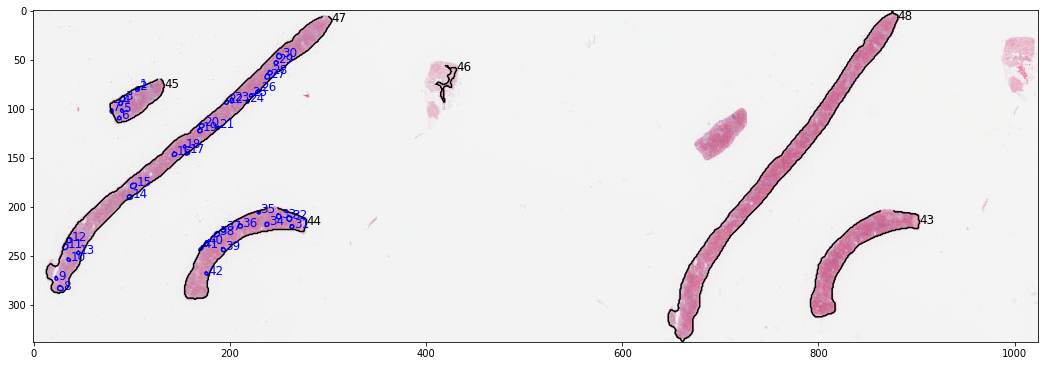

In [80]:
plt.figure(figsize = (18,10))
plt.imshow(img)
for roi in roilist:
    l = plot_contour(roi["vertices"]/ratio, c=colordict[roi['name']], name = roi['id'])

In [64]:
l_ = l[0]
l_.get_color()

'k'

##  Sample patches based on rois of hand-labelled features (glomeruli, inflammation etc)

In [2]:
from slideutils import get_region_mask

In [3]:
print("reading targeted rois")

reading targeted rois


In [16]:
def rectangle_intersection(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0: return None
    return (x, y, w, h)

In [15]:
# for roi in roilist:
#     roi['bbox'] = cv2.boundingRect(np.asarray(roi["vertices"]).round().astype(int))

In [16]:
# rect_list = [roi['bbox'] for roi in roilist]

In [17]:
# [roi['id'] for roi in roilist]

In [17]:
def get_img_id(svsname):
    imgid = re.sub("\.svs$","", os.path.basename(svsname)).replace(" ", "_").replace("-","_")
    return imgid


def get_prefix(imgid, pos, name, tissueid, id, parentdir = "data"):
    prefix = "{parentdir}/{typ}/{imgid}-{pos}-t{tissue}-r{roiid}-{typ}".format(**{
                                        "tissue":tissueid,
                                        "pos": "x{}-y{}".format(*pos),
                                        "parentdir":parentdir,
                                        "imgid":imgid,
                                        "roiid":id, 
                                        "typ": (name.replace(" ","_"))})
    return prefix

In [19]:
# ind = np.argmax([rr["area"] for rr in rois if rr['name'] !='tissue'])
# rois[ind]['name']

In [18]:
from PIL import Image
import json

In [20]:
for nn in set([rr["name"] for rr in  roilist]):
    nn = nn.replace(" ", "_")
    print(nn)
    os.makedirs("data/{}".format(nn), exist_ok=True)

tissue
glom


In [21]:
imgid = get_img_id(fnsvs)

rr = roilist[0]
prefix = get_prefix(imgid, (0,0), rr["name"], "39", rr["id"])
fnoutpng = prefix + '.png'
fnoutpng

'data/glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x0-y0-t39-r1-glom.png'

In [22]:
def summarize_rois_wi_patch(rois, bg_names = ["tissue"]):
#     ind = np.argmax([rr["area"] for rr in rois if rr['name'] not in ignore_names])
    names = []
    areas = []
    ids = []
    
    tissue_info = []
    for rr in rois:
        if rr['name'] in bg_names:
            tissue_info.append(rr)
            continue
        names.append(rr['name'])
        areas.append(rr['area'])
        ids.append(rr['id'])
        
#     assert (len(tissue_info)==1)
    tissue_id = "+".join(["%s"%tt['id'] for tt in tissue_info])
#     print("tissue_info", tissue_id)
    
    dfareas = (pd.DataFrame(dict(area=areas, name=names, id=ids))
                     .sort_values("area", ascending=False)
               )
    areasum = (dfareas.groupby('name')
                     .agg({"area":sum, "id": "first"})
                     .sort_values("area", ascending=False)
              )
    if len(areasum)==1:
        name = areasum.index[0]
        id = areasum["id"][0]
    elif areasum["area"][0]/areasum["area"][1] > 3:
        name = areasum.index[0]
        id = areasum["id"][0]
    else:
#         name = None
        name = '+'.join(areasum.index.tolist())
        id = '+'.join(areasum["id"].astype(str).tolist())
    return {"name":name, "id": str(id), "tissue_id": tissue_id, "stats": dfareas.to_dict(orient='records')}

In [ ]:
# roi_cropped_list

In [ ]:
# for reg, rois in zip(img_arr, roi_cropped_list):
#     sumdict = summarize_rois_wi_patch(rois, bg_names = ["tissue"])
# #     print(sumdict)
#     prefix = get_prefix(imgid, sumdict["name"], sumdict["tissue_id"], sumdict["id"])
#     print(prefix)

In [ ]:
# !rm data/infl/*

In [23]:
parentdir = "../data/data_1024/fullsplit/"
imgroiiter = read_roi_patches_from_slide(slide, roilist,
                        target_size = [1024]*2,
                        maxarea = 1e7,
                        nchannels=3,
                        allcomponents=True,
                       )

for reg, rois,_, start_xy in imgroiiter:
    sumdict = summarize_rois_wi_patch(rois, bg_names = ["tissue"])
    
#     name = sumdict["name"]
#     id = sumdict["id"]
#     prefix = get_prefix(imgid, sumdict["name"], sumdict["tissue_id"], sumdict["id"] )
    prefix = get_prefix(imgid, start_xy, sumdict["name"], sumdict["tissue_id"], sumdict["id"],
                       parentdir=parentdir)
    fnjson = prefix + ".json"
    os.makedirs(os.path.dirname(fnjson), exist_ok=True)
    
    with open(fnjson, 'w+') as fhj: json.dump( sumdict, fhj)
    fnoutpng = prefix + '.png'
    Image.fromarray(reg).save(fnoutpng)
    print(fnoutpng)


../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x47919-y6822-t59-r1-glom.png
../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x37442-y16429-t59-r2-glom.png
../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x37818-y17313-t59-r3-glom.png
../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x34916-y18442-t59-r4-glom.png
../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x32650-y18094-t59-r5-glom.png
../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x30802-y21400-t59-r6-glom.png
../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x30387-y22009-t59-r7-glom.png
../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x29433-y20683-t59-r8-glom.png
../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db70411f2ea518a6e6da3-x29132-y21368-t59-r9-glom.png
../data/data_1024/fullsplit//glom/6b8110e5dfccd8b3665db7

KeyboardInterrupt: 

In [28]:
x,y,w,h = rois[0]["bbox"]
x + w//2, y + h//2

(15782, 22552)

In [24]:
# Visualization with a np array:
def visualise_chunks_and_rois_arr(img_arr, roi_cropped_list,
                              nrows = 5, figsize=(15,15)
                             ):
    fig, axs = plt.subplots(nrows,len(img_arr)//nrows, figsize=figsize)
    for ax, reg, rois in zip(axs.ravel(), img_arr, roi_cropped_list):
        ax.imshow(reg)
        for rr in rois:
            if rr['name'] == 'tissue':
                continue
            plot_contour(rr["vertices"], ax=ax)
        ax.set_xlabel("\n".join(["{}: {}".format(rr['id'], rr['name']) for rr in rois if rr['name'] !='tissue']))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

In [25]:
# Visualization with a generator:
def visualise_chunks_and_rois(imgroiiter, numrois,
                              nrows = 5, figsize=(15,15)
                             ):
    fig, axs = plt.subplots(nrows, numrois//nrows, figsize=figsize)
    for ax, (reg, rois,_, start_xy) in zip(axs.ravel(),imgroiiter):
        ax.imshow(reg)
        for rr in rois:
            if rr['name'] == 'tissue':
                continue
            plot_contour(rr["vertices"], ax=ax)
        ax.set_xlabel("\n".join(["{}: {}".format(rr['id'], rr['name']) for rr in rois if rr['name'] !='tissue']))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

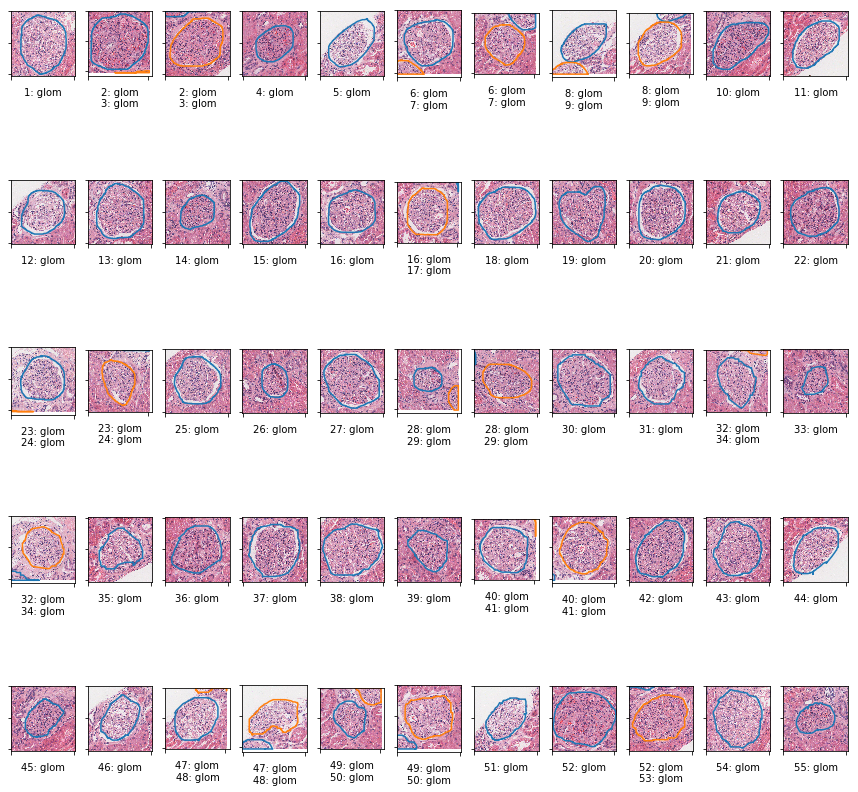

In [26]:
maxarea = 1e7
imgroiiter = read_roi_patches_from_slide(slide, roilist,
                        target_size = [1024]*2,
                        maxarea = maxarea,
                        nchannels=3,
                        allcomponents=True,
                       )

numrois = sum((1 for roi in roilist if not (maxarea is not None and (roi['area'] > maxarea))))
        
visualise_chunks_and_rois(imgroiiter, numrois,
                              nrows = 5, figsize=(15,15)
                             )

## Sample unspecific tissue rois

In [27]:
outdir = "../data/"
os.makedirs(outdir, exist_ok=True)

In [28]:
def save_tissue_chunks(imgroiiter, imgid):
    for ii, (reg, rois,_, start_xy) in enumerate(imgroiiter):
        sumdict = summarize_rois_wi_patch(rois, bg_names = [])
        prefix = get_prefix(imgid, start_xy, sumdict["name"], sumdict["id"], ii)
        fnjson = prefix + ".json"
        fnoutpng = prefix + '.png'
        print(prefix)
        os.makedirs(os.path.dirname(fnjson), exist_ok=True)
        with open(fnjson, 'w+') as fhj: json.dump( sumdict, fhj)
        if isinstance(reg, Image.Image):
            reg.save(fnoutpng)
        else:
            Image.fromarray(reg).save(fnoutpng)

In [29]:
def get_tissue_rois(slide,
                    roilist,
                    vis = False,
                    step = 1024,
                    target_size = None,
                    maxarea = 1e7,
                    random=False,
                   ):

    target_size = [step]*2

    tissue_rois = [roi for roi in roilist if roi['name']=='tissue']

    for roi in tissue_rois:
        print("id", roi["id"])
        cont = roi["vertices"]
        points = sample_points_wi_contour(cont,
                                      step = step,
                                      shift = -step//2,
                                      random=random)

        pointroilist = [{"vertices":[pp], "area":0} for pp in points]
        
#         img_arr, roi_cropped_list, msk_arr, = \
        imgroiiter = read_roi_patches_from_slide(slide, 
                                        pointroilist,
                                        but_list = roilist,
                                        target_size = target_size,
                                        maxarea = maxarea,
                                        color=1,
                                        nchannels=None,
                                        allcomponents = True,
                                        nomask=True,
                                       )
#         if vis:
#             plt.scatter(points[:,0], points[:,1],c='r')
#             plot_contour(cont)
        # filter for rois with only normal tissue 
        normal_tissue_only_iter = filter(lambda x: all(roi['name']=='tissue' for roi in x[1]), imgroiiter )

#         print(next(normal_tissue_only_iter))
        # save
        save_tissue_chunks(normal_tissue_only_iter, imgid)

In [ ]:
print("reading and saving (normal) tissue rois")

get_tissue_rois(slide,
                    roilist,
                    vis = False,
                    step = 1024,
                    target_size = None,
                    maxarea = 1e7,
                    random=False,
                   )

In [ ]:
# nrows = 5
# nimg = len(roi_cropped_list)
# fig, axs = plt.subplots(nrows, nimg//nrows, figsize=(15,15))
# for ax, reg, rois in zip(axs.ravel(),
#                          img_arr,
#                          roi_cropped_normal_list):
#     ax.imshow(reg)
#     ax.set_xlabel(", ".join(list(set([roi["name"] for roi in rois]))))
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     for roi in rois:
#         plot_contour(roi["vertices"], ax=ax)
# #         print(roi["name"], round(roi["areafraction"],2),roi["area"], sep='\t')

In [ ]:
# nn = 17
# plt.imshow(img_arr[nn])
# for roi in roi_cropped_list[nn]:
#     plot_contour(roi["vertices"])
#     print(roi["name"], round(roi["areafraction"],2),roi["area"], sep='\t')